# YOLO Accident Detection - Clean Implementation

A streamlined accident detection system using YOLOv8.

## Setup and Installation

In [3]:
!pip install ultralytics opencv-python matplotlib pillow "numpy<2.0"
from IPython.display import clear_output
clear_output()
print("✅ Installation complete!")

✅ Installation complete!


## Import Libraries

In [4]:
from ultralytics import YOLO
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
print(np.__version__)
%matplotlib inline

1.26.4


## Load Model

In [17]:
model = YOLO("yolov8n.pt")
print(f"✅ Model loaded with {len(model.names)} classes")

✅ Model loaded with 80 classes


## Object Detection Function

In [18]:
def detect_objects(image_path, conf_threshold=0.25):
    if not os.path.exists(image_path):
        return []
    
    results = model.predict(source=image_path, conf=conf_threshold, verbose=False)
    detections = []
    
    if results and results[0].boxes is not None:
        boxes = results[0].boxes
        for i in range(len(boxes)):
            conf = float(boxes.conf[i])
            if conf >= conf_threshold:
                cls_id = int(boxes.cls[i])
                box = boxes.xyxy[i].cpu().numpy().tolist()
                detections.append({
                    'class_name': results[0].names[cls_id],
                    'confidence': conf,
                    'box': box,
                    'center': [(box[0] + box[2]) / 2, (box[1] + box[3]) / 2]
                })
    return detections

## Visualization Function

In [19]:
def visualize_results(image_path, detections, title="Detection Results"):
    image = cv2.imread(image_path)
    if image is None:
        return None
    
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    ax.imshow(image_rgb)
    
    colors = plt.cm.Set3(np.linspace(0, 1, 12))
    
    for i, det in enumerate(detections):
        x1, y1, x2, y2 = map(int, det['box'])
        color = colors[i % len(colors)]
        
        rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, 
                           edgecolor=color, facecolor='none')
        ax.add_patch(rect)
        
        label = f"{det['class_name']} ({det['confidence']:.2f})"
        ax.text(x1, y1-5, label, bbox=dict(boxstyle="round", facecolor=color, alpha=0.8),
                fontsize=9, color='white', weight='bold')
    
    ax.set_title(title, fontsize=14, weight='bold')
    ax.axis('off')
    plt.tight_layout()
    plt.show()
    return fig

## Accident Detection Logic

In [20]:
def detect_accident(detections):
    accident_keywords = ['accident', 'crash', 'collision', 'fire', 'smoke', 'debris']
    accident_found = False
    indicators = []
    
    # Check for accident keywords
    for det in detections:
        if any(keyword in det['class_name'].lower() for keyword in accident_keywords):
            accident_found = True
            indicators.append(f"Direct: {det['class_name']}")
    
    # Check vehicle proximity
    vehicles = [d for d in detections if any(v in d['class_name'].lower() 
                                           for v in ['car', 'truck', 'bus', 'motorcycle'])]
    
    for i, v1 in enumerate(vehicles):
        for v2 in vehicles[i+1:]:
            dx = v1['center'][0] - v2['center'][0]
            dy = v1['center'][1] - v2['center'][1]
            distance = np.sqrt(dx**2 + dy**2)
            
            if distance < 50:
                accident_found = True
                indicators.append(f"Proximity: {v1['class_name']} & {v2['class_name']}")
    
    return {
        'accident_detected': accident_found,
        'indicators': indicators,
        'risk_level': 'HIGH' if accident_found else 'LOW'
    }

## Complete Analysis Workflow

In [21]:
def analyze_image(image_path, conf_threshold=0.25):
    print(f"🔍 Analyzing: {os.path.basename(image_path)}")
    
    # Detection
    detections = detect_objects(image_path, conf_threshold)
    accident_result = detect_accident(detections)
    
    # Results
    print(f"Objects detected: {len(detections)}")
    if detections:
        classes = {}
        for det in detections:
            classes[det['class_name']] = classes.get(det['class_name'], 0) + 1
        for cls, count in classes.items():
            print(f"  • {cls}: {count}")
    
    # Accident status
    if accident_result['accident_detected']:
        print("🚨 POTENTIAL ACCIDENT DETECTED!")
        for indicator in accident_result['indicators']:
            print(f"  • {indicator}")
    else:
        print("✅ No accidents detected")
    
    # Visualization
    title = "🚨 ACCIDENT DETECTED" if accident_result['accident_detected'] else "✅ Normal Scene"
    visualize_results(image_path, detections, title)
    
    return detections, accident_result

## Batch Processing

In [22]:
def process_multiple_images(image_folder):
    supported_formats = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff')
    image_files = [f for f in os.listdir(image_folder) 
                   if f.lower().endswith(supported_formats)]
    
    results = []
    for image_file in image_files:
        image_path = os.path.join(image_folder, image_file)
        detections, accident_result = analyze_image(image_path)
        results.append({
            'file': image_file,
            'detections': len(detections),
            'accident': accident_result['accident_detected']
        })
        print("-" * 50)
    
    # Summary
    print(f"\n📊 BATCH SUMMARY")
    total_accidents = sum(1 for r in results if r['accident'])
    print(f"Images processed: {len(results)}")
    print(f"Accidents detected: {total_accidents}")
    
    return results

## Usage Examples

1.26.4
🔍 Analyzing: testing1.jpg
Objects detected: 1
  • car: 1
✅ No accidents detected


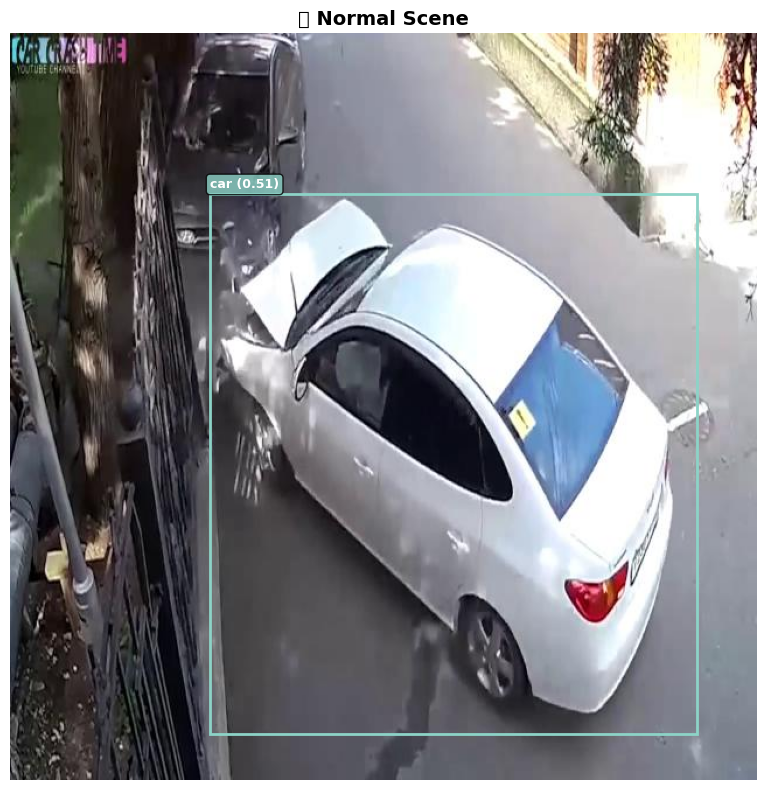

🔍 Analyzing: testing1.jpg
Objects detected: 1
  • car: 1
✅ No accidents detected


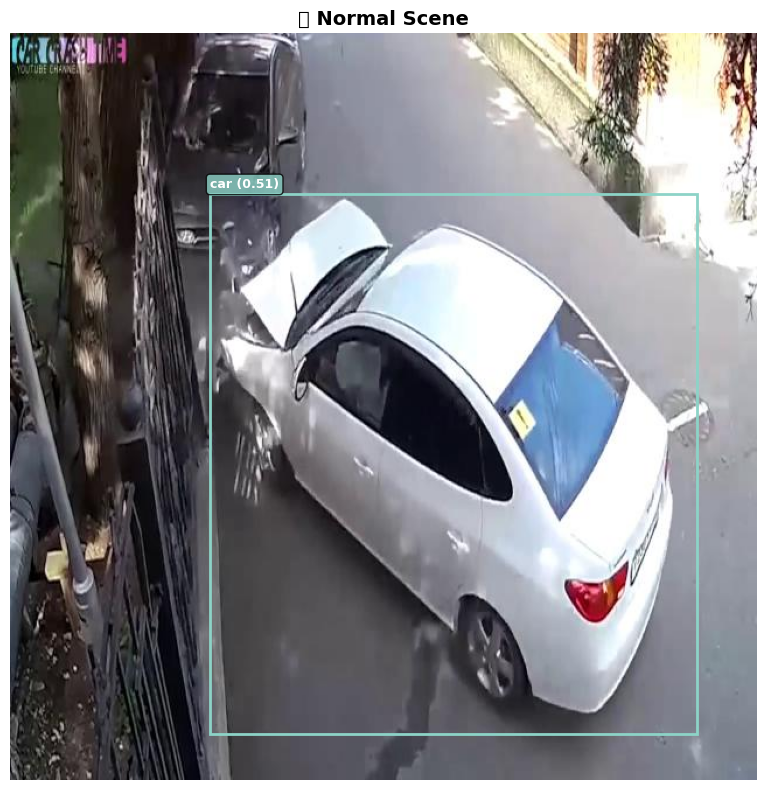

--------------------------------------------------

📊 BATCH SUMMARY
Images processed: 1
Accidents detected: 0
🔍 Analyzing: testing1.jpg
Objects detected: 1
  • car: 1
✅ No accidents detected


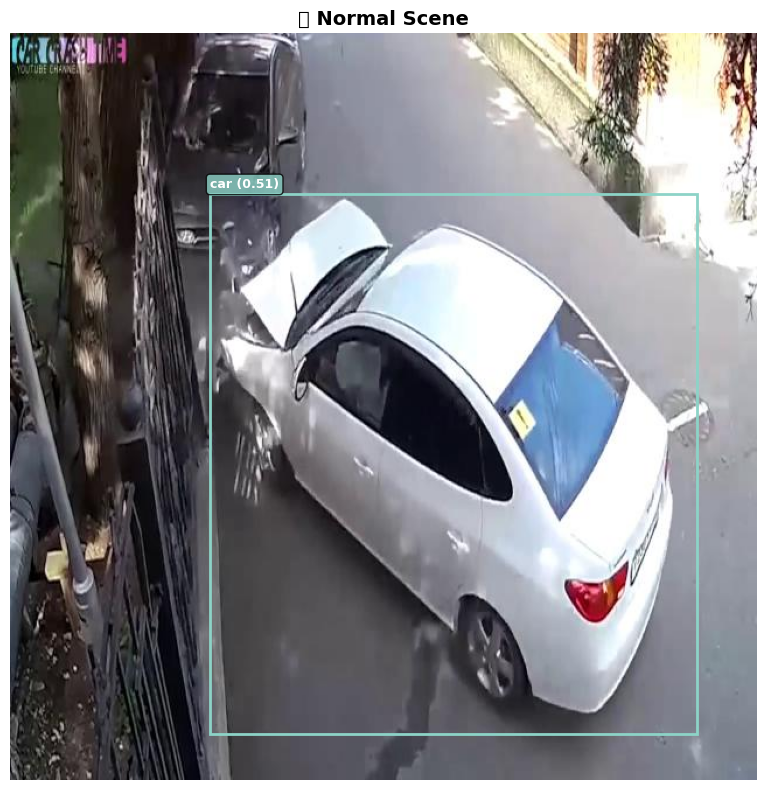

In [33]:
print(np.__version__)

# Single image analysis
image_path = "/Users/aslahyasar/Desktop/Accident/Accident-Detection-Model/data/testing1.jpg"
detections, accident_result = analyze_image(image_path)

# Batch processing
folder_path = "/Users/aslahyasar/Desktop/Accident/Accident-Detection-Model/data"
batch_results = process_multiple_images(folder_path)

# Custom confidence threshold
detections, accident_result = analyze_image(image_path, conf_threshold=0.45)

## Model Training (Optional)

In [34]:
def train_custom_model(data_yaml="data.yaml", epochs=25):
    if not os.path.exists(data_yaml):
        print("❌ Data config file not found")
        return None
    
    results = model.train(
        data=data_yaml,
        epochs=epochs,
        imgsz=640,
        batch=16,
        device='cpu',
        patience=20,
        save=True,
        plots=True,
        hsv_h=0.015, hsv_s=0.7, hsv_v=0.4,  # color jitter
        degrees=10, translate=0.1, scale=0.5, shear=2.0,  # geometric augmentations
        flipud=0.1, fliplr=0.5,  # flipping
        mosaic=1.0, mixup=0.1,  # advanced augmentation
    )

    return results

# Uncomment to train on custom dataset
results = train_custom_model()

Ultralytics 8.3.158 🚀 Python-3.10.18 torch-2.7.1 CPU (Apple M4)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=10, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.1, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.1, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train195, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=20, perspective=0.0, plots=True, pose=12.0, pretrained=True, profile=False, project=None, re

train: Scanning /Users/aslahyasar/Desktop/Accident/Accident-Detection-Model/data/train/labels.cache... 947 images, 446 backgrounds, 0 corrupt: 100%|██████████| 947/947 [00:00<?, ?it/s]

val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 285.4±111.4 MB/s, size: 50.9 KB)



val: Scanning /Users/aslahyasar/Desktop/Accident/Accident-Detection-Model/data/valid/labels.cache... 154 images, 18 backgrounds, 0 corrupt: 100%|██████████| 154/154 [00:00<?, ?it/s]

Plotting labels to runs/detect/train195/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/train195
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25         0G      1.546      1.395      1.565          4        640: 100%|██████████| 60/60 [03:41<00:00,  3.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:16<00:00,  3.25s/it]

                   all        154        170      0.645      0.418      0.514      0.214

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       2/25         0G      1.621      1.444      1.605          4        640: 100%|██████████| 60/60 [03:50<00:00,  3.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:18<00:00,  3.66s/it]

                   all        154        170      0.543      0.412      0.439        0.2

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       3/25         0G      1.671      1.595      1.689          4        640: 100%|██████████| 60/60 [04:06<00:00,  4.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:19<00:00,  3.80s/it]

                   all        154        170      0.508      0.376      0.405        0.2

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       4/25         0G      1.687       1.65      1.688          2        640: 100%|██████████| 60/60 [04:10<00:00,  4.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:18<00:00,  3.76s/it]

                   all        154        170      0.982      0.326      0.464      0.213

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       5/25         0G       1.69      1.658      1.668          5        640: 100%|██████████| 60/60 [04:03<00:00,  4.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:18<00:00,  3.75s/it]

                   all        154        170      0.717      0.347      0.419      0.187

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       6/25         0G       1.67      1.551      1.678          2        640: 100%|██████████| 60/60 [04:03<00:00,  4.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:18<00:00,  3.77s/it]

                   all        154        170      0.493      0.372      0.362       0.14

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       7/25         0G      1.708      1.581      1.728          5        640: 100%|██████████| 60/60 [04:03<00:00,  4.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:19<00:00,  3.91s/it]

                   all        154        170      0.759      0.394      0.483      0.236

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       8/25         0G      1.634      1.462      1.659          4        640: 100%|██████████| 60/60 [04:03<00:00,  4.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:18<00:00,  3.77s/it]

                   all        154        170       0.77      0.441      0.493      0.223

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       9/25         0G      1.631      1.484      1.636          3        640: 100%|██████████| 60/60 [04:04<00:00,  4.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:19<00:00,  3.81s/it]

                   all        154        170      0.815        0.4      0.482      0.223

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      10/25         0G      1.648      1.397       1.63          4        640: 100%|██████████| 60/60 [04:08<00:00,  4.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:19<00:00,  3.90s/it]

                   all        154        170      0.729      0.396      0.504      0.232

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      11/25         0G      1.628      1.414      1.624          6        640: 100%|██████████| 60/60 [04:12<00:00,  4.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:22<00:00,  4.43s/it]

                   all        154        170      0.907      0.324      0.426      0.206

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      12/25         0G      1.619      1.421      1.631          1        640: 100%|██████████| 60/60 [04:22<00:00,  4.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:19<00:00,  3.81s/it]

                   all        154        170      0.597      0.435      0.458      0.202

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      13/25         0G      1.561        1.4      1.594          0        640: 100%|██████████| 60/60 [04:25<00:00,  4.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:20<00:00,  4.11s/it]

                   all        154        170      0.736      0.371      0.459      0.211

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      14/25         0G      1.597      1.343       1.63          4        640: 100%|██████████| 60/60 [04:49<00:00,  4.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:19<00:00,  3.88s/it]

                   all        154        170      0.684      0.318      0.432      0.192

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      15/25         0G      1.535       1.29      1.575          5        640: 100%|██████████| 60/60 [04:31<00:00,  4.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:26<00:00,  5.28s/it]

                   all        154        170      0.817      0.306      0.443      0.227
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      16/25         0G      1.479     0.9741      1.559          2        640: 100%|██████████| 60/60 [06:17<00:00,  6.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:25<00:00,  5.08s/it]

                   all        154        170      0.654      0.494      0.593      0.273

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      17/25         0G      1.407     0.8469      1.503          2        640: 100%|██████████| 60/60 [04:54<00:00,  4.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:18<00:00,  3.70s/it]

                   all        154        170      0.712      0.453      0.517      0.262

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      18/25         0G      1.459     0.8686      1.512          3        640: 100%|██████████| 60/60 [04:01<00:00,  4.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:19<00:00,  3.86s/it]

                   all        154        170      0.792      0.371      0.485      0.246

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      19/25         0G      1.415      0.868      1.526          1        640: 100%|██████████| 60/60 [04:03<00:00,  4.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:18<00:00,  3.75s/it]

                   all        154        170      0.712      0.421      0.517      0.249

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      20/25         0G       1.33     0.8021      1.445          0        640: 100%|██████████| 60/60 [04:09<00:00,  4.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:19<00:00,  3.94s/it]

                   all        154        170      0.665      0.453      0.512      0.255

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      21/25         0G      1.365     0.7709      1.468          2        640: 100%|██████████| 60/60 [04:15<00:00,  4.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:20<00:00,  4.19s/it]

                   all        154        170      0.575      0.494      0.532      0.265

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      22/25         0G      1.382     0.7597      1.497          2        640: 100%|██████████| 60/60 [04:28<00:00,  4.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:19<00:00,  4.00s/it]

                   all        154        170      0.663      0.465      0.516      0.249

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      23/25         0G      1.299     0.7507      1.423          1        640: 100%|██████████| 60/60 [04:14<00:00,  4.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:19<00:00,  3.89s/it]

                   all        154        170      0.707      0.488      0.576      0.268

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      24/25         0G      1.345     0.7051      1.466          2        640: 100%|██████████| 60/60 [04:26<00:00,  4.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:22<00:00,  4.40s/it]

                   all        154        170      0.768      0.476      0.556      0.252

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      25/25         0G      1.297      0.721      1.424          2        640: 100%|██████████| 60/60 [04:39<00:00,  4.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:20<00:00,  4.02s/it]

                   all        154        170      0.764      0.482      0.549      0.257

25 epochs completed in 1.941 hours.
Optimizer stripped from runs/detect/train195/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train195/weights/best.pt, 6.2MB

Validating runs/detect/train195/weights/best.pt...
Ultralytics 8.3.158 🚀 Python-3.10.18 torch-2.7.1 CPU (Apple M4)


Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:19<00:00,  3.81s/it]


                   all        154        170      0.654      0.494      0.597      0.273
Speed: 1.1ms preprocess, 117.5ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/detect/train195


In [35]:
results = model.val(data="data.yaml")

Ultralytics 8.3.158 🚀 Python-3.10.18 torch-2.7.1 CPU (Apple M4)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2120.6±267.8 MB/s, size: 54.0 KB)


val: Scanning /Users/aslahyasar/Desktop/Accident/Accident-Detection-Model/data/valid/labels.cache... 154 images, 18 backgrounds, 0 corrupt: 100%|██████████| 154/154 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:17<00:00,  1.73s/it]


                   all        154        170      0.654      0.494      0.597      0.273
Speed: 0.7ms preprocess, 109.9ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/detect/train1952


## Export Trained Model

In [36]:
def export_model(format='onnx'):
    model.export(format=format)
    print(f"✅ Model exported to {format} format")

export_model('onnx')  # Uncomment to export

Ultralytics 8.3.158 🚀 Python-3.10.18 torch-2.7.1 CPU (Apple M4)

PyTorch: starting from 'runs/detect/train195/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 5, 8400) (6.0 MB)

ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: slimming with onnxslim 0.1.58...
ONNX: export success ✅ 0.4s, saved as 'runs/detect/train195/weights/best.onnx' (11.7 MB)

Export complete (0.5s)
Results saved to /Users/aslahyasar/Desktop/Accident/Accident-Detection-Model/runs/detect/train195/weights
Predict:         yolo predict task=detect model=runs/detect/train195/weights/best.onnx imgsz=640  
Validate:        yolo val task=detect model=runs/detect/train195/weights/best.onnx imgsz=640 data=data.yaml  
Visualize:       https://netron.app
✅ Model exported to onnx format


---

## Quick Start Guide

1. **Install dependencies**: Run the setup cell
2. **Load model**: Execute the model loading cell
3. **Analyze single image**: Use `analyze_image("your_image.jpg")`
4. **Process multiple images**: Use `process_multiple_images("your_folder/")`
5. **Train custom model**: Prepare dataset and use training function

## Notes

- Supports common image formats (JPG, PNG, BMP, TIFF)
- Adjust `conf_threshold` for detection sensitivity
- For custom accident classes, modify `accident_keywords` list
- Training requires properly formatted YOLO dataset